In [ ]:
import tensorflow as tf
print(f"tensorflow {tf.__version__}")

device = "gpu" if tf.config.list_physical_devices('GPU') else "cpu"
print(f"device: {device}")

tensorflow 2.9.2
device: gpu


# Kaggle Fruits 360 with pre-trained ResNet50 as feature extractor

https://www.kaggle.com/datasets/moltean/fruits

### Download the data

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip
!unzip -nq 'fruits-360.zip'
!ls fruits-360

--2022-11-12 22:17:42--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  1.01MB/s    in 2m 42s  

2022-11-12 22:20:26 (1.12 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]

LICENSE  papers  readme.md  test-multiple_fruits  Training  Validation


K=60, Ntrain=28736, Ntest=9673

IMAGE_SHAPE=(100, 100, 3)



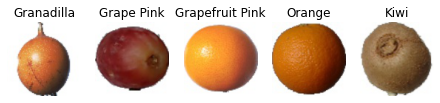

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

train_path = 'fruits-360/Training'
val_path = 'fruits-360/Validation'

# Get list of train and validation image files
p = Path('.')
classes = [x.name for x in list(p.glob(train_path + '/*'))]
train_files = list((p / train_path).glob('**/*.jp*g'))
val_files = list((p / val_path).glob('**/*.jp*g'))

# Get number of classes and set sizes
K = len(classes)
N_train = len(train_files)
N_val = len(val_files)
print(f"K={K}, Ntrain={N_train}, Ntest={N_val}")

# Get image size
with Image.open(np.random.choice(train_files)) as im:
  IMAGE_SIZE = im.size
  IMAGE_SHAPE = (*IMAGE_SIZE, len(im.getbands()))  # including color channels
print(f"\nIMAGE_SHAPE={IMAGE_SHAPE}\n")

# Show some examples
n = 5
px = 1/plt.rcParams['figure.dpi'] # pixel per inches
random_files = np.random.choice(train_files, n)
fig, ax = plt.subplots(ncols=n, figsize=tuple(1.1*n*x*px for x in IMAGE_SIZE))
for i in range(n):
  with Image.open(random_files[i]) as im:
    ax[i].imshow(np.asarray(im))
    ax[i].set_axis_off()
    ax[i].set_title(random_files[i].parent.name)
plt.show()

### Data loaders

We need to define data loaders with data augmentation (for the train set) and including the preprocess_input transformation required by the pre-trained model (both for train and validation sets).

In [ ]:
# Data Augmentation
import tensorflow.keras.applications.resnet50 as resnet50

BATCH_SIZE = 32

'''
# ImageDataGenerator supports real-time data augmentation.
# First we create a generator with the data transformations,
# then a directory iterator with flow_from_directory.
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range = 20,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  shear_range = 0.1,
  zoom_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True,
  preprocessing_function = resnet50.preprocess_input
)
train_ds = train_gen.flow_from_directory(
  directory = train_path,
  target_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  shuffle = True,
  class_mode = 'sparse'
)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
  preprocessing_function = resnet50.preprocess_input
)
val_ds = val_gen.flow_from_directory(
  directory = val_path,
  target_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  shuffle = False,
  class_mode = 'sparse'
)

classes = train_ds.class_indices
'''

# Note that ImageDataGenerator is deprecated and one should use
# image_dataset_from_directory to create a Dataset object.
# Data augmentation is not supported by image_dataset_from_directory,
# and we need to use Dataset.map together with augmentation layers.
augment_input = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomTranslation(0.1, 0.1),

  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomFlip("horizontal_and_vertical")
])

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = train_path,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  shuffle = True
).map(
  lambda x, y: (resnet50.preprocess_input(augment_input(x)), y)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory = val_path,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE,
  shuffle = False
).map(
  lambda x, y: (resnet50.preprocess_input(x), y)
)

# Improve performance 
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 28736 files belonging to 60 classes.


Found 9673 files belonging to 60 classes.


### Define the Model

Model: we use ResNet50 pre-trained on ImageNet as feature extractor, and we add a Dense(100) layer and a final Dense(K) output layer.

In [ ]:
# Model definition
import tensorflow.keras.applications.resnet50 as resnet50

# Use ResNet50 as non-trainable feature extractor
feature_extractor = resnet50.ResNet50(weights='imagenet', input_shape=IMAGE_SHAPE,
                                      include_top=False, pooling='avg')
for layer in feature_extractor.layers:
  layer.trainable = False

i = feature_extractor.input
x = feature_extractor.output  # shape=(2048,) with global pooling
# x = tf.keras.layers.GlobalAveragePooling1D()(x)  # included in the model import with pooling='avg'
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.Dense(K)(x)
model = tf.keras.Model(i, x)

model.summary()

94765736/94765736 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

### Fit and evaluate

In [ ]:
# Compile and fit model
EPOCHS = 5

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

r = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/5
898/898 [==============================] - 157s 162ms/step - loss: 0.2716 - accuracy: 0.9259 - val_loss: 0.1411 - val_accuracy: 0.9497
Epoch 2/5
898/898 [==============================] - 35s 38ms/step - loss: 0.0409 - accuracy: 0.9868 - val_loss: 0.1363 - val_accuracy: 0.9546
Epoch 3/5
898/898 [==============================] - 36s 40ms/step - loss: 0.0529 - accuracy: 0.9839 - val_loss: 0.1125 - val_accuracy: 0.9642
Epoch 4/5
898/898 [==============================] - 35s 40ms/step - loss: 0.0278 - accuracy: 0.9905 - val_loss: 0.0983 - val_accuracy: 0.9665
Epoch 5/5
898/898 [==============================] - 37s 41ms/step - loss: 0.0483 - accuracy: 0.9867 - val_loss: 0.1668 - val_accuracy: 0.9578


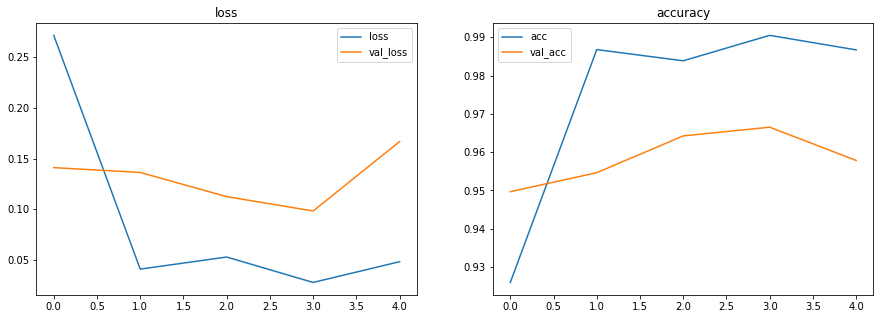

In [ ]:
# Plot loss and accuracy per epoch
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(r.history['loss'], label='loss')
ax[0].plot(r.history['val_loss'], label='val_loss')
ax[0].set_title('loss')
ax[0].legend()
ax[1].plot(r.history['accuracy'], label='acc')
ax[1].plot(r.history['val_accuracy'], label='val_acc')
ax[1].set_title('accuracy')
ax[1].legend();

In [ ]:
# Calculate the confusion matrix on the validation set
predictions = []
targets = []
for batch, (X, y) in enumerate(val_ds):
  p = np.argmax(model.predict(X), axis=1)
  predictions = np.concatenate((predictions, p))
  targets = np.concatenate((targets, y))
  if not batch % 50:
    print(f"{len(targets)} images processed")
  if len(targets) >= N_val:
    break

confmat = tf.math.confusion_matrix(targets, predictions).numpy()

1/1 [==============================] - 1s 948ms/step
32 images processed
1/1 [==============================] - 0s 24ms/step
1632 images processed
1/1 [==============================] - 0s 28ms/step
3232 images processed
1/1 [==============================] - 0s 24ms/step
4832 images processed
1/1 [==============================] - 0s 21ms/step
6432 images processed
1/1 [==============================] - 0s 22ms/step
8032 images processed
1/1 [==============================] - 0s 24ms/step
9632 images processed
1/1 [==============================] - 1s 806ms/step


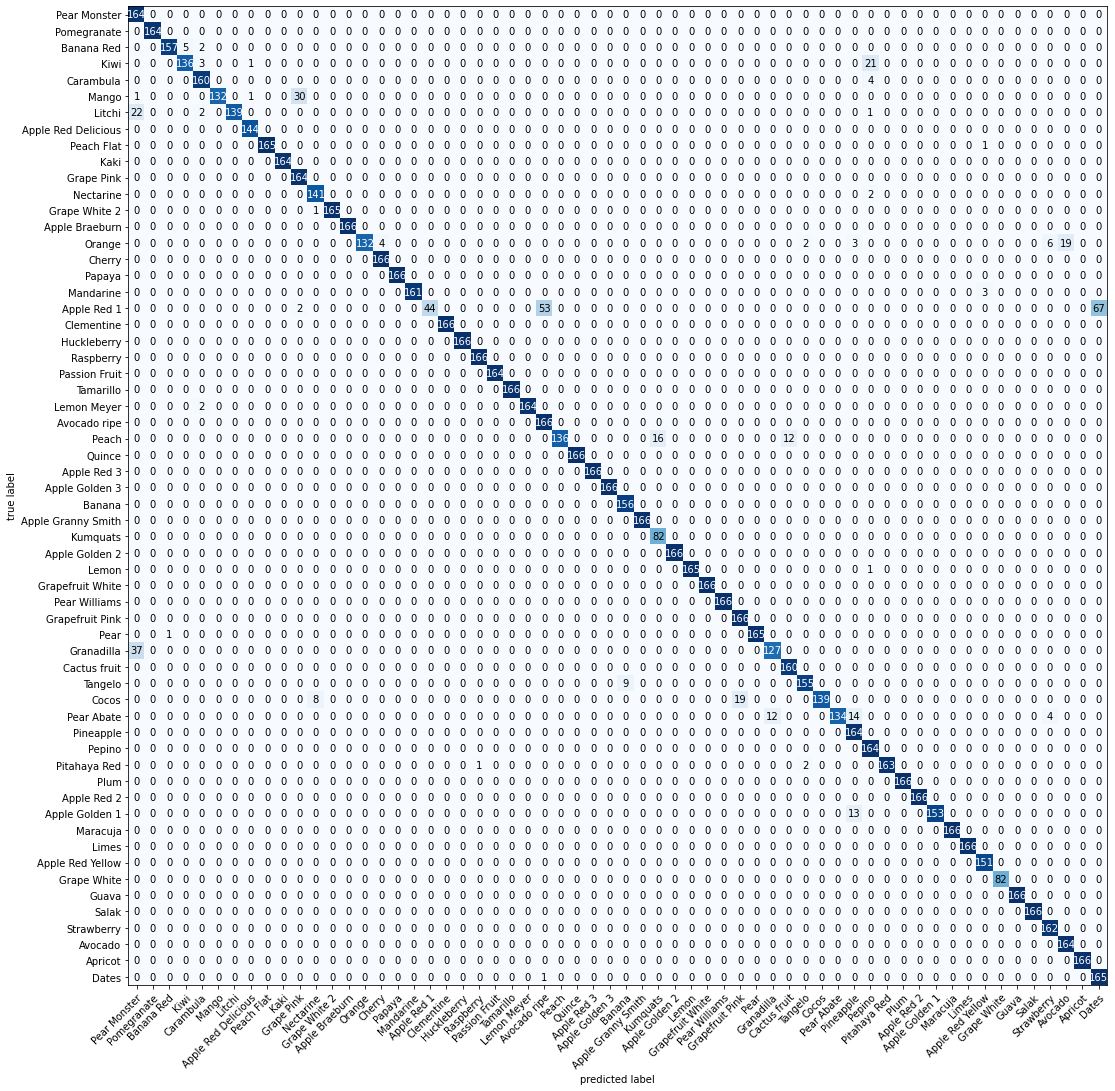

In [ ]:
# Install package to plot the confusion matrix
!pip -q install -U mlxtend
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(confmat, class_names=classes, figsize=(18,18));

# Blood cells with own implementation of ResNet50 (TODO..)

https://www.kaggle.com/datasets/paultimothymooney/blood-cells

In [ ]:
# 